In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import shap

import sys, os, json
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model
# print the JS visualization code to the notebook
shap.initjs()

In [2]:
#Parameters to change, can change model_type to 'best' or 'last'
modelname = 'MultiBody8-Subjettiness_massTrue_ptTrue_best_baseline'
#modelname = 'MultiBody8-Subjettiness_massTrue_ptTrue_best_tau_x_1'
model_dict = json.load(open('../../models/Multi-Body/trained_model_dicts/' + modelname.replace("_best", "") + ".json"))
use_jet_pt = model_dict['use_pt']
use_jet_mass = model_dict['use_mass']
tau_x_1 = model_dict['tau_x_1']
N = model_dict['N']
extra_name = model_dict['label']
hidden = list(map(int, model_dict['nodes'].split(',')))
# use_jet_pt = True
# use_jet_mass = True
# tau_x_1 = False
# N = 8
# extra_name = ''

model_type = 'best'
if extra_name != '' and not extra_name.startswith('_'):
    extra_name = '_' + extra_name
if tau_x_1 and 'tau_x_1' not in extra_name:
    extra_name += '_tau_x_1'

#Training/Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'
train_path = '../../datasets/n-subjettiness_data/train_all.npy'

#model path
model_path = '../../models/Multi-Body/trained_models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+\
             '_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#Loading training/testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)
train_set = MultiDataset(train_path, N, use_jet_pt, use_jet_mass, tau_x_1)
training_data, train_label = train_set[:]
testing_data, test_label = test_set[:]
testing_data_bkg = testing_data[np.where(test_label[:,1]==0)[0]]
testing_data_sig = testing_data[np.where(test_label[:,1]==1)[0]]
    
#loading model
model = Model(N, use_jet_pt, use_jet_mass, tau_x_1, hidden).cuda()
model.load_state_dict(torch.load(model_path))
model = model.cuda()
model.eval()

Net(
  (_nn): Sequential(
    (0): Sequential(
      (0): Linear(in_features=22, out_features=200, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=200, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=50, out_features=2, bias=True)
      (1): Identity()
      (2): Identity()
    )
  )
  (softmax): Softmax(dim=1)
)

In [3]:
labels = []
if not tau_x_1:
    for i in range(N-1):
        if i != N-2:
            labels.append('tau_'+str(i+1)+'_'+str(0.5))
            labels.append('tau_'+str(i+1)+'_'+str(1))
            labels.append('tau_'+str(i+1)+'_'+str(2))
        else:
            labels.append('tau_'+str(i+1)+'_'+str(1))
            labels.append('tau_'+str(i+1)+'_'+str(2))
    if use_jet_pt:
        labels.append('jet_pt')
    if use_jet_mass:
        labels.append('jet_mass')
else:
    for i in range(N-1):
        labels.append('tau_'+str(i+1)+'_'+str(1))
    if use_jet_pt:
        labels.append('jet_pt')
    if use_jet_mass:
        labels.append('jet_mass')

In [4]:
def predict(arr):
    with torch.no_grad():
        return model(torch.from_numpy(arr).float().cuda()).cpu().detach().numpy()

In [5]:
reevaluate = False

In [6]:
# use Kernel SHAP to explain test set predictions
# 10,000 training and 100 testing samples took me 1:45-2:15 hours
# Don't need to do this if already run, can use pickle.load
if reevaluate:
    training = shap.sample(training_data, 5000)
    explainer = shap.KernelExplainer(predict, training)

In [7]:
if reevaluate:
    samples_sig = shap.sample(testing_data_sig, 500)
    shap_values_sig = explainer.shap_values(samples_sig, nsamples=50)

In [8]:
if reevaluate:
    samples_bkg = shap.sample(testing_data_bkg, 500)
    shap_values_bkg = explainer.shap_values(samples_bkg, nsamples=50)

In [9]:
#Saving shap_values, expected_value, and samples
folder = 'shap_info'+ '_'+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+extra_name
if not os.path.exists(folder):
    os.mkdir(folder)
if reevaluate:
    with open(folder+"/training"+extra_name+".pkl", "wb") as f:
         pickle.dump(training, f)
    with open(folder+"/expected_value"+extra_name+".pkl", "wb") as f:
         pickle.dump(explainer.expected_value, f)
            
    with open(folder+"/shap_values_bkg"+extra_name+".pkl", "wb") as f:
         pickle.dump(shap_values_bkg, f)
    with open(folder+"/samples_bkg"+extra_name+".pkl", "wb") as f:
         pickle.dump(samples_bkg, f)
            
    with open(folder+"/shap_values_sig"+extra_name+".pkl", "wb") as f:
         pickle.dump(shap_values_sig, f)
    with open(folder+"/samples_sig"+extra_name+".pkl", "wb") as f:
         pickle.dump(samples_sig, f)
    

In [10]:
#Loading shap_values, expected_value, and samples

with open(folder+"/shap_values_bkg"+extra_name+".pkl", "rb") as f:
    shap_values_bkg = pickle.load(f)
with open(folder+"/samples_bkg"+extra_name+".pkl", "rb") as f:
     samples_bkg = pickle.load(f)
with open(folder+"/shap_values_sig"+extra_name+".pkl", "rb") as f:
    shap_values_sig = pickle.load(f)
with open(folder+"/samples_sig"+extra_name+".pkl", "rb") as f:
     samples_sig = pickle.load(f)

with open(folder+"/training"+extra_name+".pkl", "rb") as f:
     training = pickle.load(f)
with open(folder+"/expected_value"+extra_name+".pkl", "rb") as f:
     expected_value = pickle.load(f)

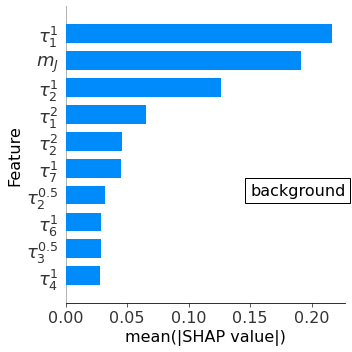

In [37]:
plt.figure(figsize=(5,5))
shap.summary_plot(shap_values_bkg[0], samples_bkg, 
                  max_display = 10, class_names="Background", 
                  plot_type = "bar", show=False, 
                  feature_names=labels, plot_size=None)
#plt.title("TopoDNN Background Shap Values")
plt.tick_params(axis='x', which='major', labelsize=16)
#plt.tick_params(axis='y', which='major', labelsize=18)
plt.xlabel('mean(|SHAP value|)', fontsize=16)
plt.ylabel('Feature', fontsize=16)
feat_names = [f.get_text() for f in plt.yticks()[1]]
tag_labels = []
for feat in feat_names:
    if feat == 'jet_pt':
        tag_labels.append('$p_{T,J}$')
    elif feat == 'jet_mass':
        tag_labels.append('$m_J$')
    else:
        x, y = feat.split('_')[1], feat.split('_')[2]
        tag_labels.append(r'$\tau_' + x + '^{' + y + '}$')
plt.yticks(np.arange(0,len(tag_labels),1), tag_labels, fontsize=18)
plt.text(0.15, 3, "background", fontsize=16, bbox=dict(boxstyle='Square', facecolor='white'))
plt.tight_layout()
plt.savefig("figures/SHAP_MB8S_{}_bkg.png".format(extra_name.strip('_') if extra_name else 'baseline'))
plt.show()

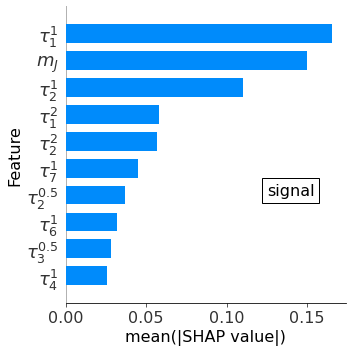

In [39]:
plt.figure(figsize=(5,5))
shap.summary_plot(shap_values_sig[1], samples_sig, 
                  max_display = 10, class_names="Signal", 
                  plot_type = "bar", show=False, 
                  feature_names=labels, plot_size=None)
#plt.title("TopoDNN Background Shap Values")
plt.tick_params(axis='x', which='major', labelsize=16)
plt.xlabel('mean(|SHAP value|)', fontsize=16)
plt.ylabel('Feature', fontsize=16)
tag_labels = []
for feat in feat_names:
    if feat == 'jet_pt':
        tag_labels.append('$p_{T,J}$')
    elif feat == 'jet_mass':
        tag_labels.append('$m_J$')
    else:
        x, y = feat.split('_')[1], feat.split('_')[2]
        tag_labels.append(r'$\tau_' + x + '^{' + y + '}$')
plt.yticks(np.arange(0,len(tag_labels),1), tag_labels, fontsize=18)
plt.text(0.125, 3, "signal", fontsize=16, bbox=dict(boxstyle='Square', facecolor='white'))
plt.tight_layout()
plt.savefig("figures/SHAP_MB8S_{}_sig.png".format(extra_name.strip('_') if extra_name else 'baseline'))
plt.show()

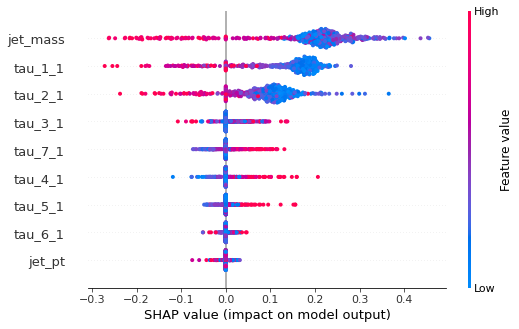

In [41]:
shap.summary_plot(shap_values_bkg[0], samples_bkg, feature_names=labels, max_display = 10, 
                  plot_type = "dot", show=False)
#plt.title("Multi-Body "+" Shap Distribution")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.show()

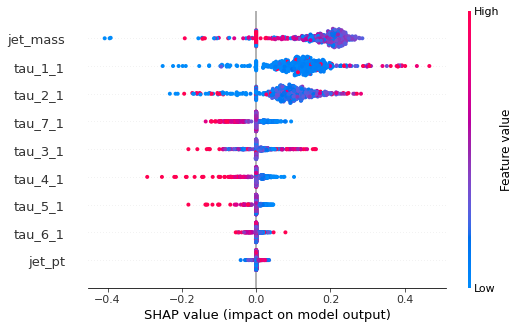

In [42]:
shap.summary_plot(shap_values_sig[1], samples_sig, feature_names=labels, max_display = 10, 
                  plot_type = "dot", show=False)
#plt.title("Multi-Body "+" Shap Distribution")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.show()